In [1]:
import time
import numpy as np
import gym
from gym import spaces
from collections import defaultdict
import math
import itertools
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import plotly.graph_objects as go
import pandas as pd
import time

# Environment

In [30]:
class SmartCharging(gym.Env):
    def __init__(self, actions, cap, stuck_penalty):
        super(SmartCharging, self).__init__()
        
        self.actions = actions  
        self.cap = cap
        self.stuck_penalty = stuck_penalty
        
        self.episode = 0 #Current training episode. This is used in the random start training after n episodes.
        self.old_level = 0 #Battery level at the end of the last episode.
        self.stuck = False
        self.action_space = spaces.Discrete(len(self.actions))
        self.observation_space = spaces.Dict({
            'level': spaces.Discrete(self.cap+1),
            'time': spaces.Discrete(8)
        })
        
        self.state = {
            'level': 0,
            'time': 0
        }      
        
        self.done = False
        
    def reset(self):
        self.state = {
            'level': self.old_level,
            'time': 0
        }
        self.done = False
        return self.state
    
    def reset_random(self):
        self.state = {
            'level': np.random.randint(0,100),
            'time': np.random.randint(0,7)
        }
        self.done = False
        return self.state

    def reset_episode(self): #Call this after every training!
        self.episode=0

    def step(self, action):
        loaded = self.actions.get(action) #Determines how much kWh are loaded.
        reward = 0

        if loaded + self.state['level'] > self.cap: #Loading would exceed battery capacity.
            reward -= cost_func(self.state['time'], self.cap - self.state['level']) #Only receive cost for actually loaded kWh below capcity.
            self.state['level'] = self.cap
        else:
            reward -= cost_func(self.state['time'], loaded)
            self.state['level'] += loaded

        self.state['time'] += 1

        if self.state['time'] == 8: #Terminal state. 
            consumed = power_consumed()
            if self.state['level'] - consumed >= 0: #Car had enough energy for the day.
                self.old_level = self.state['level'] - consumed
                self.stuck = False
            else: #Car gets stuck.
                self.old_level = 0
                self.stuck = True
                reward += self.stuck_penalty
                
            self.reset()
                
            self.episode += 1
            self.done = True
            
        return self.state, reward, self.done, self.stuck
    
def cost_func(t, p):
    '''
    This method returns the costs for charging
    @param t:  time
    @param p:  charging rate
    '''
    # alpha_time is the coefficient for time
    alpha_time = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
    #alpha_time = [1,1,1,1,1,1,1,1] 
    return alpha_time[t] * math.exp(p/2)

def power_consumed(mu=30, sigma=5):
    '''
    This method returns power consumed by the taxi driver
    @param mu: mean
    @param sigma: standard deviation
    '''
    return int(np.random.normal(mu, sigma, 1)[0])

# Agents

## Monte Carlo 

In [3]:
class MC_Agent():
    def __init__(self, alpha, gamma, env, epsilon, epsilon_decay, epsilon_min,alpha_decay): 
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.alpha_decay = alpha_decay
        
        self.action_space_size = self.env.action_space.n 
        self.q_table = defaultdict(lambda: np.zeros(self.action_space_size))
        self.q_table_count = defaultdict(lambda: np.zeros(self.action_space_size))

    def pick_action(self, state):
        action_q_values = self.q_table.get((state['time'], state['level']), np.zeros(self.action_space_size))
        # Initialize Q-values for new state (not in table yet) with all actions to 0.  
        return self.epsilon_greedy(action_q_values)

    def epsilon_greedy(self, action_q_values):
        if np.random.rand() < self.epsilon or np.all(action_q_values==0): #Probability ε or state was never visited before.
            # Exploration: Choose a random action
            chosen_action = np.random.choice(range(self.action_space_size))
        else:
            # Exploitation: Choose the action with the highest Q-value.
            chosen_action = np.argmax(action_q_values)

        if self.epsilon > self.epsilon_min: 
            self.epsilon *= self.epsilon_decay

        return chosen_action

    def update_q_values(self, state, action, goal): #Update via Monte Carlo update rules.
        state_key = (state['time'], state['level'])
        
        if self.alpha_decay:
            self.q_table_count[state_key][action] += 1
            learning_rate = self.alpha / self.q_table_count[state_key][action] #Alpha decay. Each visit at the same State reduces the learn rate.
            self.q_table[state_key][action] += learning_rate * (goal - self.q_table[state_key][action])
        else:
            self.q_table[state_key][action] += self.alpha * (goal - self.q_table[state_key][action])
        
    def train(self, iterations,random_iter):
        for i in range(iterations):
            if i < random_iter: #Train with random initial state.
                current_state = self.env.reset_random()
            else:
                current_state = self.env.reset()
                
            episode = []
            done = False
            
            while not done: #Go through one episode until terminal state is reached.         
                action = self.pick_action(current_state)
                old_state = current_state.copy()
                current_state, reward, done, _ = self.env.step(action)
                episode.append((old_state, action, reward))

            goal = 0
            for state, action, reward in reversed(episode): #Traverse episode backwards and apply Monte Carlo rules.
                goal = reward + self.gamma * goal
                self.update_q_values(state, action, goal)
                
        self.env.reset_episode()
        return self.q_table

## SARSA

In [4]:
class SARSA_Agent():
    def __init__(self, alpha, gamma, env, epsilon, epsilon_decay, epsilon_min,alpha_decay):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.alpha_decay = alpha_decay
        
        self.action_space_size = env.action_space.n
        self.q_table = defaultdict(lambda: np.zeros(self.action_space_size))
        self.q_table_count = defaultdict(lambda: np.zeros(self.action_space_size))

    def pick_action(self, state):
        action_q_values = self.q_table.get((state['time'], state['level']), np.zeros(self.action_space_size))
        # Initialize Q-values for new state (not in table yet) with all actions to 0.  
        return self.epsilon_greedy(action_q_values)

    def epsilon_greedy(self, action_q_values):
        if np.random.rand() < self.epsilon or np.all(action_q_values==0): #Probability ε or state was never visited before.
            # Exploration: Choose a random action
            chosen_action = np.random.choice(range(self.action_space_size))
        else:
            # Exploitation: Choose the action with the highest Q-value.
            chosen_action = np.argmax(action_q_values)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return chosen_action

    def update_q_values(self, state, action, reward, next_state, next_action, done): #Update via SARSA update rules.
        state_key = (state['time'], state['level'])
        next_state_key = (next_state['time'], next_state['level'])

        td_target = reward + self.gamma * self.q_table[next_state_key][next_action] * (1 - done) #Set everything to 0 if done.
        td_error = td_target - self.q_table[state_key][action]
        
        if self.alpha_decay:
            self.q_table_count[state_key][action] += 1
            learning_rate = self.alpha / self.q_table_count[state_key][action] #Alpha decay. Each visit at the same State reduces the learn rate.
            self.q_table[state_key][action] += learning_rate * td_error
        else:
            self.q_table[state_key][action] += self.alpha * td_error
                
    def train(self, iterations,random_iter):
        for i in range(iterations):
            if i < random_iter: #Train with random initial state.
                state = self.env.reset_random()
            else:
                state = self.env.reset()
            action = self.pick_action(state)
            done = False

            while not done: #Go through one episode until terminal state is reached. 
                next_state, reward, done, _ = self.env.step(action)
                next_action = self.pick_action(next_state)

                self.update_q_values(state, action, reward, next_state, next_action, done)

                state = next_state.copy()
                action = next_action
        
        self.env.reset_episode()
        return self.q_table

## Q Learning

In [18]:
class DQN_Agent():
    def __init__(self, env, alpha, gamma, epsilon, epsilon_decay, epsilon_min, alpha_decay, memory_size, batch_size, target_update=10):
        self.env = env
        self.state_size = 2  # time and level
        self.action_size = env.action_space.n 
        self.alpha = alpha  # Initial learning rate
        self.gamma = gamma  
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay 
        self.epsilon_min = epsilon_min
        self.alpha_decay = alpha_decay
        self.batch_size = batch_size  
        self.target_update = target_update  

        # Experience replay memory
        self.memory = deque(maxlen=memory_size)

        # Initialize Q-table count for alpha decay
        self.q_table_count = {}

        # Main network
        self.model = self.build_model()

        # Target Q-network
        self.target_model = self.build_model()
        self.update_target_model()
        
        # Stochastic optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.alpha)

    def build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),  # Input layer
            nn.ReLU(), 
            nn.Linear(64, 64),  # Hidden layer
            nn.ReLU(), 
            nn.Linear(64, self.action_size)  # Output layer (number of actions)
        )
        return model

    def update_target_model(self):
        # Copy weights from main Q-network to target network.
        self.target_model.load_state_dict(self.model.state_dict())

    def pick_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Exploration: random action
        state = torch.FloatTensor(state).unsqueeze(0)  # Convert state to tensor and add batch dimension
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()  # Exploitation: choose action with highest Q-value

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
        # Initialize or update the count for state-action pair
        state_key = tuple(state)
        if state_key not in self.q_table_count:
            self.q_table_count[state_key] = [0] * self.action_size
        self.q_table_count[state_key][action] += 1

    def replay(self):
        # Perform experience replay if enough samples are available.
        if len(self.memory) < self.batch_size:
            return 

        minibatch = random.sample(self.memor


## Deep Q-Network

In [48]:
class DQN_Agent():
    def __init__(self, env, alpha, gamma, epsilon, epsilon_decay, epsilon_min, alpha_decay, alpha_min, memory_size, batch_size, target_update=10):
        self.env = env
        self.state_size = 2  # time and level
        self.action_size = env.action_space.n 
        self.alpha = alpha  # Initial learning rate
        self.gamma = gamma  
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay 
        self.epsilon_min = epsilon_min
        self.alpha_decay = alpha_decay  # Decay rate for learning rate
        self.alpha_min = alpha_min      # Minimum learning rate
        self.batch_size = batch_size  
        self.target_update = target_update  

        # Experience replay memory
        self.memory = deque(maxlen=memory_size)

        # Main network
        self.model = self.build_model()

        # Target Q-network
        self.target_model = self.build_model()
        self.update_target_model()
        
        # Stochastic optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.alpha)

    def build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),  # Input layer
            nn.ReLU(), 
            nn.Linear(64, 64),  # Hidden layer
            nn.ReLU(), 
            nn.Linear(64, self.action_size)  # Output layer (number of actions)
        )
        return model

    def update_target_model(self):
        # Copy weights from main Q-network to target network.
        self.target_model.load_state_dict(self.model.state_dict())

    def pick_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Exploration: random action
        state = torch.FloatTensor(state).unsqueeze(0)  # Convert state to tensor and add batch dimension
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()  # Exploitation: choose action with highest Q-value

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        # Perform experience replay if enough samples are available.
        if len(self.memory) < self.batch_size:
            return 

        minibatch = random.sample(self.memory, self.batch_size)

        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            
            target = reward
            if not done:
                target += self.gamma * torch.max(self.target_model(next_state)).item() # Calculate target as reward + discounted max future Q-value.
            
            target_f = self.model(state).clone().detach() # Current Q-value for selected action.
            target_f[action] = target

            loss = nn.MSELoss()(self.model(state), target_f)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.alpha = max(self.alpha_min, self.alpha * self.alpha_decay)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.alpha

    def generate_state_space_keys(self):
        state_space_keys = []
        for time in range(self.env.observation_space['time'].n):
            for level in range(self.env.observation_space['level'].n):
                state_space_keys.append((time, level))
        return state_space_keys

    def extract_q_table(self):
        q_table = {}
        state_space_keys = self.generate_state_space_keys()

        for state_key in state_space_keys:
            state = torch.FloatTensor(state_key).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state).numpy().flatten()
            q_table[state_key] = q_values

        return q_table

    def train(self, episodes, random_iter):
        for e in range(episodes):
            if e < random_iter:  # Train with random initial state for exploration
                state = self.env.reset_random()
            else:
                state = self.env.reset()
            state = np.array([state['time'], state['level']])

            done = False
            total_reward = 0

            while not done:  # Go through one episode until terminal state is reached
                action = self.pick_action(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.array([next_state['time'], next_state['level']])
                total_reward += reward

                self.store_experience(state, action, reward, next_state, done)
                state = next_state
                self.replay()

            # Update target model periodically.
            if e % self.target_update == 0:
                self.update_target_model()

            print(f"Episode {e+1}/{episodes} - Reward: {total_reward}")

        self.env.reset_episode()
        return self.extract_q_table()

In [52]:
class DQN_Agent_old():
    def __init__(self, env, alpha, gamma, epsilon, epsilon_decay, epsilon_min, memory_size, batch_size, target_update=10):
        self.env = env
        self.state_size = 2  #time and level
        self.action_size = env.action_space.n 
        self.alpha = alpha  
        self.gamma = gamma  
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay 
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size  # Number of samples per batch for replay.
        self.target_update = target_update  # Frequency to update target network.

        # Experience replay memory
        self.memory = deque(maxlen=memory_size)

        # Main network
        self.model = self.build_model()

        # Target Q-network
        self.target_model = self.build_model()
        self.update_target_model()
        
        # Stochastic optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.alpha)

    def build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 64),  # Input layer
            nn.ReLU(), 
            nn.Linear(64, 64),  # Hidden laye
            nn.ReLU(), 
            nn.Linear(64, self.action_size)  # Output layer (number of actions)
        )
        return model

    def update_target_model(self):
        # Copy weights from main Q-network to target network.
        self.target_model.load_state_dict(self.model.state_dict())

    def pick_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Exploration: random action
        state = torch.FloatTensor(state).unsqueeze(0)  # Convert state to tensor and add batch dimension
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()  # Exploitation: choose action with highest Q-value

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        # Perform experience replay if enough samples are available.
        if len(self.memory) < self.batch_size:
            return 

        minibatch = random.sample(self.memory, self.batch_size)

        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            
            target = reward
            if not done:
                target += self.gamma * torch.max(self.target_model(next_state)).item() # Calculate target as reward + discounted max future Q-value.
            
            target_f = self.model(state).clone().detach() # Current Q-value for selected action.
            target_f[action] = target

            loss = nn.MSELoss()(self.model(state), target_f)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def generate_state_space_keys(self):
        # Generate all possible state keys based on the environment's observation space
        state_space_keys = []
        for time in range(self.env.observation_space['time'].n):
            for level in range(self.env.observation_space['level'].n):
                state_space_keys.append((time, level))
        return state_space_keys

    def extract_q_table(self):
        # Extract the Q-table by evaluating the model over all possible states
        q_table = {}
        state_space_keys = self.generate_state_space_keys()

        for state_key in state_space_keys:
            state = torch.FloatTensor(state_key).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state).numpy().flatten()
            q_table[state_key] = q_values

        return q_table

    def train(self, episodes, random_iter):
        for e in range(episodes):
            # Reset environment for each episode
            if e < random_iter:  # Train with random initial state for exploration
                state = self.env.reset_random()
            else:
                state = self.env.reset()
            state = np.array([state['time'], state['level']])  # Convert state to array

            done = False
            total_reward = 0

            while not done:  # Go through one episode until terminal state is reached
                action = self.pick_action(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.array([next_state['time'], next_state['level']])
                total_reward += reward

                # Store experience and train the model
                self.store_experience(state, action, reward, next_state, done)
                state = next_state
                self.replay()

            # Update the target model periodically
            if e % self.target_update == 0:
                self.update_target_model()

            # Print progress
            print(f"Episode {e+1}/{episodes} - Reward: {total_reward}, Epsilon: {self.epsilon:.2f}")

        # Reset the environment and extract the final Q-table
        self.env.reset_episode()
        return self.extract_q_table()

# Evaluation methods

In [15]:
def plot_q_table_3d(q_table, cap):
    """
    Plots a 3D surface of the Q-table showing the relationship between 
    battery level, time, and Q-values.

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values for different actions.
    - cap (int): The maximum battery level.
    """

    def get_Z(key):
        return np.average(q_table[key])

    # battery level
    X = np.arange(cap + 1)
    # time
    Y = np.arange(8)
    X_grid, Y_grid = np.meshgrid(X, Y)
    # average Q-values (policy)
    Z = np.array([get_Z(key) for key in itertools.product(Y, X)]).reshape((8, cap + 1))

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X_grid, Y_grid, -Z, cmap='viridis')

    ax.view_init(elev=30, azim=45)

    ax.set_zlabel('Average Q-value')
    ax.set_ylabel('Time')
    ax.set_xlabel('Battery level')
    plt.tight_layout()
    plt.show()

def plot_q_table_2d(q_table):
    """
    Plots a 2D heatmap of the average Q-values over all actions for each state in the Q-table.

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values for different actions.
    """

    levels = sorted(set(state[1] for state in q_table.keys()))
    times = sorted(set(state[0] for state in q_table.keys()))

    # Initialize a matrix with zeros
    q_matrix = np.zeros((len(levels), len(times)))

    # Fill the matrix with average Q-values
    for state_key, q_values in q_table.items():
        time, level = state_key
        if level in levels and time in times:
            level_idx = levels.index(level)
            time_idx = times.index(time)
            q_matrix[level_idx, time_idx] = np.mean(q_values)

    fig, ax = plt.subplots(figsize=(len(times), len(levels)))
    cax = ax.matshow(q_matrix, cmap='viridis')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(times)))
    ax.set_xticklabels(times)
    ax.set_yticks(np.arange(len(levels)))
    ax.set_yticklabels(levels)

    # Annotate the matrix with Q-values
    for i in range(len(levels)):
        for j in range(len(times)):
            value = q_matrix[i, j]
            ax.text(j, i, f"{value:.2f}", ha='center', va='center', color='white')

    ax.set_xlabel('Time')
    ax.set_ylabel('Battery Level')
    plt.title('Average Q-Value')
    plt.show()

def plot_greedy_policy(q_table):
    """
    Plots the greedy policy by displaying the action with the highest Q-value for each state.

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values for different actions.
    """

    action_labels = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very high'}

    levels = sorted(set(state[1] for state in q_table.keys()))
    times = sorted(set(state[0] for state in q_table.keys()))

    action_matrix = np.zeros((len(levels), len(times)))

    # Populate the matrix with the best actions
    for state_key, q_values in q_table.items():
        time, level = state_key
        if level in levels and time in times:
            level_idx = levels.index(level)
            time_idx = times.index(time)
            best_action = np.argmax(q_values)
            action_matrix[level_idx, time_idx] = best_action

    fig, ax = plt.subplots(figsize=(12, 8))
    cax = ax.matshow(action_matrix, cmap='viridis', vmin=0, vmax=len(action_labels) - 1)

    cbar = fig.colorbar(cax, ticks=list(action_labels.keys()))
    cbar.ax.set_yticklabels([action_labels[i] for i in action_labels.keys()])

    xticks = np.arange(len(times))
    yticks = np.arange(len(levels))

    y_ticks_interval = max(1, len(levels) // 10)
    ax.set_yticks(yticks[::y_ticks_interval])
    ax.set_yticklabels([levels[i] for i in yticks[::y_ticks_interval]])

    x_ticks_interval = max(1, len(times) // 10)
    ax.set_xticks(xticks[::x_ticks_interval])
    ax.set_xticklabels([times[i] for i in xticks[::x_ticks_interval]])

    plt.xlabel('Time')
    plt.ylabel('Battery Level')
    plt.title('Greedy Policy (Actions)')
    ax.grid(False)
    plt.show()

def evaluate_q_table(q_table, env, num_episodes=100):
    """
    Evaluate the performance of the Q-table over a number of episodes.

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values for different actions.
    - env (gym.Env): The environment to evaluate.
    - num_episodes (int): Number of episodes to evaluate.

    Returns:
    - float: The average reward obtained over the episodes.
    - int: The count of episodes where the agent got stuck.
    """

    total_reward = 0
    stuck_count = 0

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            state_key = (state['time'], state['level'])
            if state_key in q_table:
                action = np.argmax(q_table[state_key])
            else:
                action = 0  # No action = no loading
            
            next_state, reward, done, stuck = env.step(action)
            episode_reward += reward
            state = next_state

        total_reward += episode_reward
        if stuck:
            stuck_count += 1

    average_reward = total_reward / num_episodes
    
    return average_reward, stuck_count

def calculate_empty_q_percentage(q_table):
    """
    Calculate the percentage of Q-values in the Q-table that are empty (equal to 0).

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values.

    Returns:
    - float: The percentage of empty Q-values in the Q-table.
    """

    total_q_values = 0
    empty_q_values = 0

    for state_key, q_values in q_table.items():
        total_q_values += len(q_values)
        empty_q_values += sum(q == 0 for q in q_values)  # Define empty as q == 0

    if total_q_values == 0:
        return 0.0

    percentage_empty = (empty_q_values / total_q_values) * 100
    return percentage_empty

def parallel_coordinates_plot(q_table, actions, max_time, max_level):
    """
    Creates a parallel coordinates plot to visualize the transitions of battery levels over time
    based on the actions taken.

    Parameters:
    - q_table (dict): The Q-table where keys are state tuples and values are lists/arrays of Q-values for different actions.
    - actions (list): List of possible actions.
    - max_time (int): Maximum time value in the environment.
    - max_level (int): Maximum battery level in the environment.
    """

    data = []

    for time in range(max_time + 1):
        for level in range(max_level + 1):
            q_values = q_table.get((time, level), [0] * len(actions))
            max_action_index = np.argmax(q_values)
            max_action_kwh = actions[max_action_index]
            data.append({
                'Time': time,
                'Battery_level': level,
                'Best_action_kwh': max_action_kwh,
                'Future_battery_level': level + max_action_kwh if level + max_action_kwh < max_level else max_level
            })
    
    df = pd.DataFrame(data)

    unique_actions = df['Best_action_kwh'].unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_actions)))
    color_map = {action: f'rgb{tuple((c[:3] * 255).astype(int))}' for action, c in zip(unique_actions, colors)}

    fig = go.Figure()
    for action in unique_actions:
        action_data = df[df['Best_action_kwh'] == action]

        for i in range(len(action_data) - 1):
            x_values = [action_data.iloc[i]['Time'], action_data.iloc[i]['Time'] + 1]
            y_values = [action_data.iloc[i]['Battery_level'], action_data.iloc[i]['Future_battery_level']]

            scatters = go.Scatter(
                x=x_values,
                y=y_values,
                mode='lines+markers',
                line=dict(width=2, color=color_map.get(action, 'gray')),
                name=f'Action {action}' if i == 0 else f'Action {action}',
                showlegend=i == 0  # Only show legend for the first line of each action
            )

            fig.add_trace(scatters)

    fig.update_layout(
        title='Battery Level Transitions Over Time',
        xaxis_title='Time',
        yaxis_title='Battery Level'
    )
    fig.show()

def grid_search(agent_function, iteration_list, alpha_list, gamma_list, epsilon_decay_list, test_episodes, num_subiter):
    """
    Perform a grid search to find the optimal hyperparameters for the agent.

    Parameters:
    - agent_function (function): The function that creates the agent.
    - iteration_list (list): List of possible iteration values.
    - alpha_list (list): List of possible alpha values.
    - gamma_list (list): List of possible gamma values.
    - epsilon_decay_list (list): List of possible epsilon decay values.
    - test_episodes (int): Number of episodes to evaluate for each parameter combination.
    - num_subiter (int): Number of sub-iterations to run for averaging.

    Returns:
    - dict: A dictionary containing the average rewards for each parameter combination.
    """

    average_rewards = {}

    for iteration in iteration_list:
        for alpha in alpha_list:
            for gamma in gamma_list:
                for epsilon_decay in epsilon_decay_list:
                    agent = agent_function(alpha=alpha, gamma=gamma, env=env, epsilon=1, epsilon_decay=epsilon_decay, epsilon_min=0.01, alpha_decay=True)
                    rewards = []
                    for _ in range(num_subiter):
                        q_table = agent.train(iteration, math.floor(iteration / 5))  # ~20% random training math.floor(iteration / 5)

                        average_reward, _ = evaluate_q_table(q_table, env, num_episodes=test_episodes)
                        rewards.append(average_reward)

                    average_key = (iteration, alpha, gamma, epsilon_decay)
                    average_rewards[average_key] = np.mean(rewards)
                    print(f"Average reward for {average_key}: {average_rewards[average_key]}")
    return average_rewards

def plot_grid_search(*avg_rewards_list, labels=None):
    """
    Plots the results of a grid search as separate line plots for each hyperparameter.
    This version accepts multiple avg_rewards dictionaries and plots them on the same figure.

    Parameters:
    - avg_rewards_list (list of dicts): A list of dictionaries containing the average rewards for each hyperparameter combination.
    - labels (list of str): A list of labels corresponding to each avg_rewards dictionary.
    """
    
    # Prepare for plotting multiple lines
    if labels is None:
        labels = [f'Run {i+1}' for i in range(len(avg_rewards_list))]

    plt.figure(figsize=(12, 8))

    # Create plots for each parameter
    for avg_rewards, label in zip(avg_rewards_list, labels):
        iteration_sums = defaultdict(float)
        iteration_counts = defaultdict(int)

        alpha_sums = defaultdict(float)
        alpha_counts = defaultdict(int)

        gamma_sums = defaultdict(float)
        gamma_counts = defaultdict(int)

        epsilon_sums = defaultdict(float)
        epsilon_counts = defaultdict(int)

        for (iteration, alpha, gamma, epsilon), reward in avg_rewards.items():
            iteration_sums[iteration] += reward
            iteration_counts[iteration] += 1

            alpha_sums[alpha] += reward
            alpha_counts[alpha] += 1

            gamma_sums[gamma] += reward
            gamma_counts[gamma] += 1

            epsilon_sums[epsilon] += reward
            epsilon_counts[epsilon] += 1

        iteration_averages = {k: iteration_sums[k] / iteration_counts[k] for k in iteration_sums}
        alpha_averages = {k: alpha_sums[k] / alpha_counts[k] for k in alpha_sums}
        gamma_averages = {k: gamma_sums[k] / gamma_counts[k] for k in gamma_sums}
        epsilon_averages = {k: epsilon_sums[k] / epsilon_counts[k] for k in epsilon_sums}

        # Plot for Iteration
        plt.subplot(2, 2, 1)
        plt.plot(list(iteration_averages.keys()), list(iteration_averages.values()), marker='o', label=label)
        plt.title('Average Reward by Iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Average Reward')

        # Plot for Alpha
        plt.subplot(2, 2, 2)
        plt.plot(list(alpha_averages.keys()), list(alpha_averages.values()), marker='o', label=label)
        plt.title('Average Reward by Alpha')
        plt.xlabel('Alpha')
        plt.ylabel('Average Reward')

        # Plot for Gamma
        plt.subplot(2, 2, 3)
        plt.plot(list(gamma_averages.keys()), list(gamma_averages.values()), marker='o', label=label)
        plt.title('Average Reward by Gamma')
        plt.xlabel('Gamma')
        plt.ylabel('Average Reward')

        # Plot for Epsilon Decay
        plt.subplot(2, 2, 4)
        plt.plot(list(epsilon_averages.keys()), list(epsilon_averages.values()), marker='o', label=label)
        plt.title('Average Reward by Epsilon Decay')
        plt.xlabel('Epsilon Decay')
        plt.ylabel('Average Reward')

    # Add legend to each subplot
    for i in range(1, 5):
        plt.subplot(2, 2, i)
        plt.legend()

    plt.tight_layout()
    plt.show()


# Execution

In [31]:
#actions = {i: i for i in range(23)}
#actions = {0: 0, 1: 1.15, 2: 1.85, 3: 2.75, 4: 5.5}
actions = {0: 0, 1: 3, 2: 7, 3: 11, 4: 17}
#Tesla Model 3, SolarEdge Home EV Charger
env = SmartCharging(actions=actions, cap=100, stuck_penalty=-30000)

In [26]:
MC_Agent1 = MC_Agent(
    alpha=1, gamma=0.9, env=env, epsilon=1, epsilon_decay=0.9, epsilon_min=0.01,alpha_decay=False
)
MC_q_table = MC_Agent1.train(100000,20000)

In [10]:
SARSA_Agent1 = SARSA_Agent(
    alpha=0.1, gamma=0.95, env=env, epsilon=1, epsilon_decay=0.99, epsilon_min=0.01,alpha_decay=False
)
SARSA_q_table = SARSA_Agent1.train(100000,20000)

In [42]:
QLearning_Agent1 = QLearning_Agent(
    alpha=0.1, gamma=0.95, env=env, epsilon=1, epsilon_decay=0.999, epsilon_min=0.01,alpha_decay=False
)
QLEARN_q_table = QLearning_Agent1.train(100000,20000)

TypeError: QLearning_Agent.__init__() got an unexpected keyword argument 'alpha_min'

In [46]:
DQN_Agent1 = DQN_Agent(
    env=env, alpha=0.1, gamma=0.95, epsilon=1, epsilon_decay=0.99, epsilon_min=0.01, alpha_decay=True,alpha_min=0.01, memory_size=10000, batch_size=32, target_update=10
)
DQN_q_table = DQN_Agent1.train(300,0)

Episode 1/300 - Reward: -3238.0684512176385, Epsilon: 1.00, Alpha: 0.10000
Episode 2/300 - Reward: -4002.7344328126637, Epsilon: 1.00, Alpha: 0.10000
Episode 3/300 - Reward: -3386.4025283179417, Epsilon: 1.00, Alpha: 0.10000
Episode 4/300 - Reward: -3230.3811221295146, Epsilon: 0.99, Alpha: 0.10000
Episode 5/300 - Reward: -3901.9117196882885, Epsilon: 0.91, Alpha: 0.10000
Episode 6/300 - Reward: -93.14105087237898, Epsilon: 0.84, Alpha: 0.10000
Episode 7/300 - Reward: -2846.9619443092984, Epsilon: 0.78, Alpha: 0.10000
Episode 8/300 - Reward: -253.272422323845, Epsilon: 0.72, Alpha: 0.10000
Episode 9/300 - Reward: -3946.619847278819, Epsilon: 0.66, Alpha: 0.10000
Episode 10/300 - Reward: -237.72998710562683, Epsilon: 0.61, Alpha: 0.10000
Episode 11/300 - Reward: -222.84205369534885, Epsilon: 0.56, Alpha: 0.10000
Episode 12/300 - Reward: -446.8387902905973, Epsilon: 0.52, Alpha: 0.10000
Episode 13/300 - Reward: -481.0904697182282, Epsilon: 0.48, Alpha: 0.10000
Episode 14/300 - Reward: -7

Episode 110/300 - Reward: -338.1953753594511, Epsilon: 0.01, Alpha: 0.10000
Episode 111/300 - Reward: -335.5841085566975, Epsilon: 0.01, Alpha: 0.10000
Episode 112/300 - Reward: -268.1889673435469, Epsilon: 0.01, Alpha: 0.10000
Episode 113/300 - Reward: -335.5841085566975, Epsilon: 0.01, Alpha: 0.10000
Episode 114/300 - Reward: -359.6706975257167, Epsilon: 0.01, Alpha: 0.10000
Episode 115/300 - Reward: -340.3759006308955, Epsilon: 0.01, Alpha: 0.10000
Episode 116/300 - Reward: -377.36043200183764, Epsilon: 0.01, Alpha: 0.10000
Episode 117/300 - Reward: -343.9709790272251, Epsilon: 0.01, Alpha: 0.10000
Episode 118/300 - Reward: -518.3530577548628, Epsilon: 0.01, Alpha: 0.10000
Episode 119/300 - Reward: -349.89826124908825, Epsilon: 0.01, Alpha: 0.10000
Episode 120/300 - Reward: -203.53403944969324, Epsilon: 0.01, Alpha: 0.10000
Episode 121/300 - Reward: -375.7827210815557, Epsilon: 0.01, Alpha: 0.10000
Episode 122/300 - Reward: -375.7827210815557, Epsilon: 0.01, Alpha: 0.10000
Episode 1

Episode 218/300 - Reward: -375.7827210815557, Epsilon: 0.01, Alpha: 0.10000
Episode 219/300 - Reward: -349.89826124908825, Epsilon: 0.01, Alpha: 0.10000
Episode 220/300 - Reward: -519.7276832176301, Epsilon: 0.01, Alpha: 0.10000
Episode 221/300 - Reward: -343.9709790272251, Epsilon: 0.01, Alpha: 0.10000
Episode 222/300 - Reward: -518.3530577548628, Epsilon: 0.01, Alpha: 0.10000
Episode 223/300 - Reward: -336.0706495097226, Epsilon: 0.01, Alpha: 0.10000
Episode 224/300 - Reward: -335.5841085566975, Epsilon: 0.01, Alpha: 0.10000
Episode 225/300 - Reward: -446.14397788363, Epsilon: 0.01, Alpha: 0.10000
Episode 226/300 - Reward: -446.14397788363, Epsilon: 0.01, Alpha: 0.10000
Episode 227/300 - Reward: -343.9709790272251, Epsilon: 0.01, Alpha: 0.10000
Episode 228/300 - Reward: -446.14397788363, Epsilon: 0.01, Alpha: 0.10000
Episode 229/300 - Reward: -349.89826124908825, Epsilon: 0.01, Alpha: 0.10000
Episode 230/300 - Reward: -343.9709790272251, Epsilon: 0.01, Alpha: 0.10000
Episode 231/300 

In [50]:
MC_avg,MC_stuck = evaluate_q_table(MC_q_table, env, num_episodes=1000)
MC_empty = calculate_empty_q_percentage(MC_q_table)
print("Monte Carlo \n Average reward: ", MC_avg ,"\n Stuck: ", MC_stuck , "\n Empty Q-values: ", MC_empty, "%")

SARSA_avg,SARSA_stuck = evaluate_q_table(SARSA_q_table, env, num_episodes=1000)
SARSA_empty = calculate_empty_q_percentage(SARSA_q_table)
print("SARSA \n Average reward: ", SARSA_avg ,"\n Stuck: ", SARSA_stuck , "\n Empty Q-values: ", SARSA_empty, "%")

QLEARN_avg,QLEARN_stuck = evaluate_q_table(QLEARN_q_table, env, num_episodes=1000)
QLEARN_empty = calculate_empty_q_percentage(QLEARN_q_table)
print("Q-Learning \n Average reward: ", QLEARN_avg ,"\n Stuck: ", QLEARN_stuck , "\n Empty Q-values: ", QLEARN_empty, "%")

DQN_avg,DQN_stuck = evaluate_q_table(DQN_q_table, env, num_episodes=1000)
DQN_empty = calculate_empty_q_percentage(DQN_q_table)
print("Deep Q-Network \n Average reward: ", DQN_avg ,"\n Stuck: ", DQN_stuck , "\n Empty Q-values: ", DQN_empty, "%")

Monte Carlo 
 Average reward:  -514.0272834558496 
 Stuck:  0 
 Empty Q-values:  0.14869888475836432 %
SARSA 
 Average reward:  -193.65985321567914 
 Stuck:  0 
 Empty Q-values:  11.069182389937108 %
Q-Learning 
 Average reward:  -77.14519523383451 
 Stuck:  0 
 Empty Q-values:  11.069182389937108 %
Deep Q-Network 
 Average reward:  -401.58990481008243 
 Stuck:  0 
 Empty Q-values:  0.0 %


In [33]:
iteration_values = [10, 20, 40, 80, 160, 300, 600,1200,3000,8000,15000]
alpha_values = [0.01,0.1,0.3,0.6,1]
gamma_values = [0.1,0.5,0.9,1]
epsilon_decay_values = [0.9,0.95,0.999]

In [34]:
avg_rewardsMC = grid_search(MC_Agent,iteration_values,alpha_values,gamma_values,epsilon_decay_values,100,3)

Average reward for (10, 0.01, 0.1, 0.9): -29507.34798286865
Average reward for (10, 0.01, 0.1, 0.95): -29407.139024535343
Average reward for (10, 0.01, 0.1, 0.999): -29306.64294083192
Average reward for (10, 0.01, 0.5, 0.9): -29306.684670798597
Average reward for (10, 0.01, 0.5, 0.95): -29506.607543659702
Average reward for (10, 0.01, 0.5, 0.999): -29306.638878861337
Average reward for (10, 0.01, 0.9, 0.9): -29406.60000000005
Average reward for (10, 0.01, 0.9, 0.95): -29406.674936054624
Average reward for (10, 0.01, 0.9, 0.999): -29406.617988726914
Average reward for (10, 0.01, 1, 0.9): -29406.685831361625
Average reward for (10, 0.01, 1, 0.95): -29406.62379154203
Average reward for (10, 0.01, 1, 0.999): -29406.760577259844
Average reward for (10, 0.1, 0.1, 0.9): -29506.66958347929
Average reward for (10, 0.1, 0.1, 0.95): -29406.607543659702
Average reward for (10, 0.1, 0.1, 0.999): -29406.62959435715
Average reward for (10, 0.1, 0.5, 0.9): -29406.60000000005
Average reward for (10, 0.

Average reward for (40, 0.1, 0.9, 0.95): -29319.439478247004
Average reward for (40, 0.1, 0.9, 0.999): -29219.526912656107
Average reward for (40, 0.1, 1, 0.9): -29119.311694411303
Average reward for (40, 0.1, 1, 0.95): -29418.970963785603
Average reward for (40, 0.1, 1, 0.999): -29506.615667600865
Average reward for (40, 0.3, 0.1, 0.9): -28147.399558223187
Average reward for (40, 0.3, 0.1, 0.95): -28592.817883718595
Average reward for (40, 0.3, 0.1, 0.999): -28355.056569138073
Average reward for (40, 0.3, 0.5, 0.9): -29407.288366665136
Average reward for (40, 0.3, 0.5, 0.95): -28327.259999433973
Average reward for (40, 0.3, 0.5, 0.999): -28726.63714246517
Average reward for (40, 0.3, 0.9, 0.9): -27756.743466739503
Average reward for (40, 0.3, 0.9, 0.95): -29311.48422037777
Average reward for (40, 0.3, 0.9, 0.999): -28943.0419124295
Average reward for (40, 0.3, 1, 0.9): -28358.009138466365
Average reward for (40, 0.3, 1, 0.95): -26928.886729509675
Average reward for (40, 0.3, 1, 0.999)

Average reward for (160, 0.6, 0.5, 0.9): -21956.20322709056
Average reward for (160, 0.6, 0.5, 0.95): -20469.016342363742
Average reward for (160, 0.6, 0.5, 0.999): -21768.977051957143
Average reward for (160, 0.6, 0.9, 0.9): -19216.917944625224
Average reward for (160, 0.6, 0.9, 0.95): -17049.760241569395
Average reward for (160, 0.6, 0.9, 0.999): -26719.483207741116
Average reward for (160, 0.6, 1, 0.9): -3644.910975377425
Average reward for (160, 0.6, 1, 0.95): -8072.809396091178
Average reward for (160, 0.6, 1, 0.999): -11279.693070276879
Average reward for (160, 1, 0.1, 0.9): -16876.668402789266
Average reward for (160, 1, 0.1, 0.95): -26624.5165144568
Average reward for (160, 1, 0.1, 0.999): -27653.393478073034
Average reward for (160, 1, 0.5, 0.9): -22168.282529285265
Average reward for (160, 1, 0.5, 0.95): -16495.30684741518
Average reward for (160, 1, 0.5, 0.999): -19008.38734132011
Average reward for (160, 1, 0.9, 0.9): -16274.239951386911
Average reward for (160, 1, 0.9, 0.9

Average reward for (600, 1, 0.9, 0.95): -173.9612912928841
Average reward for (600, 1, 0.9, 0.999): -8582.002878514782
Average reward for (600, 1, 1, 0.9): -1291.3317038034347
Average reward for (600, 1, 1, 0.95): -354.2198721118861
Average reward for (600, 1, 1, 0.999): -9955.612721088411
Average reward for (1200, 0.01, 0.1, 0.9): -621.137089783503
Average reward for (1200, 0.01, 0.1, 0.95): -1849.8747951829973
Average reward for (1200, 0.01, 0.1, 0.999): -639.9279971945627
Average reward for (1200, 0.01, 0.5, 0.9): -6715.451090648901
Average reward for (1200, 0.01, 0.5, 0.95): -4978.186467843509
Average reward for (1200, 0.01, 0.5, 0.999): -7631.2206112963395
Average reward for (1200, 0.01, 0.9, 0.9): -10111.092706328891
Average reward for (1200, 0.01, 0.9, 0.95): -191.27641799749426
Average reward for (1200, 0.01, 0.9, 0.999): -160.87298542840225
Average reward for (1200, 0.01, 1, 0.9): -276.9771771867155
Average reward for (1200, 0.01, 1, 0.95): -644.443757834391
Average reward for

Average reward for (8000, 0.01, 0.9, 0.999): -130.20076009391627
Average reward for (8000, 0.01, 1, 0.9): -266.62453681933636
Average reward for (8000, 0.01, 1, 0.95): -172.05857999060996
Average reward for (8000, 0.01, 1, 0.999): -147.68599222109046
Average reward for (8000, 0.1, 0.1, 0.9): -980.4888018461103
Average reward for (8000, 0.1, 0.1, 0.95): -1930.9954880694547
Average reward for (8000, 0.1, 0.1, 0.999): -555.1479472271009
Average reward for (8000, 0.1, 0.5, 0.9): -202.10908005938077
Average reward for (8000, 0.1, 0.5, 0.95): -190.56710495237112
Average reward for (8000, 0.1, 0.5, 0.999): -231.17819106771142
Average reward for (8000, 0.1, 0.9, 0.9): -209.71398322415493
Average reward for (8000, 0.1, 0.9, 0.95): -102.33733298132341
Average reward for (8000, 0.1, 0.9, 0.999): -146.58340330287368
Average reward for (8000, 0.1, 1, 0.9): -240.12873613919461
Average reward for (8000, 0.1, 1, 0.95): -224.4483625654342
Average reward for (8000, 0.1, 1, 0.999): -127.43318832453294
Av

In [35]:
avg_rewardsSARSA = grid_search(SARSA_Agent,iteration_values,alpha_values,gamma_values,epsilon_decay_values,100,3)

Average reward for (10, 0.01, 0.1, 0.9): -29406.608123941212
Average reward for (10, 0.01, 0.1, 0.95): -29407.168614508668
Average reward for (10, 0.01, 0.1, 0.999): -29406.6174084454
Average reward for (10, 0.01, 0.5, 0.9): -29406.608704222726
Average reward for (10, 0.01, 0.5, 0.95): -29406.617988726914
Average reward for (10, 0.01, 0.5, 0.999): -29406.684220558807
Average reward for (10, 0.01, 0.9, 0.9): -29406.758576331868
Average reward for (10, 0.01, 0.9, 0.95): -29406.60000000005
Average reward for (10, 0.01, 0.9, 0.999): -29408.975672508997
Average reward for (10, 0.01, 1, 0.9): -29307.18834408007
Average reward for (10, 0.01, 1, 0.95): -29506.60000000005
Average reward for (10, 0.01, 1, 0.999): -29506.674936054624
Average reward for (10, 0.1, 0.1, 0.9): -29306.693505062998
Average reward for (10, 0.1, 0.1, 0.95): -29506.770181962103
Average reward for (10, 0.1, 0.1, 0.999): -29406.61044506726
Average reward for (10, 0.1, 0.5, 0.9): -29506.60000000005
Average reward for (10, 0.

Average reward for (40, 0.1, 0.9, 0.9): -29130.27088053001
Average reward for (40, 0.1, 0.9, 0.95): -29418.879178956413
Average reward for (40, 0.1, 0.9, 0.999): -29408.972190819928
Average reward for (40, 0.1, 1, 0.9): -29406.71149378986
Average reward for (40, 0.1, 1, 0.95): -29407.55909136994
Average reward for (40, 0.1, 1, 0.999): -29429.401654412082
Average reward for (40, 0.3, 0.1, 0.9): -29220.874747097
Average reward for (40, 0.3, 0.1, 0.95): -24584.56080353651
Average reward for (40, 0.3, 0.1, 0.999): -29506.611605630285
Average reward for (40, 0.3, 0.5, 0.9): -28835.467682759787
Average reward for (40, 0.3, 0.5, 0.95): -28921.664068778886
Average reward for (40, 0.3, 0.5, 0.999): -29220.021021833254
Average reward for (40, 0.3, 0.9, 0.9): -29230.742134948337
Average reward for (40, 0.3, 0.9, 0.95): -29506.61624788238
Average reward for (40, 0.3, 0.9, 0.999): -29307.913389754558
Average reward for (40, 0.3, 1, 0.9): -28859.544488634852
Average reward for (40, 0.3, 1, 0.95): -2

Average reward for (160, 0.3, 1, 0.999): -29112.90768649577
Average reward for (160, 0.6, 0.1, 0.9): -29308.48421261866
Average reward for (160, 0.6, 0.1, 0.95): -29418.328517592254
Average reward for (160, 0.6, 0.1, 0.999): -29323.006793925346
Average reward for (160, 0.6, 0.5, 0.9): -29507.01284881096
Average reward for (160, 0.6, 0.5, 0.95): -29158.86039263403
Average reward for (160, 0.6, 0.5, 0.999): -29106.51422236186
Average reward for (160, 0.6, 0.9, 0.9): -29156.811488330117
Average reward for (160, 0.6, 0.9, 0.95): -28945.712170869137
Average reward for (160, 0.6, 0.9, 0.999): -28832.650315873656
Average reward for (160, 0.6, 1, 0.9): -29208.127865376082
Average reward for (160, 0.6, 1, 0.95): -29433.708565099718
Average reward for (160, 0.6, 1, 0.999): -27547.238490398046
Average reward for (160, 1, 0.1, 0.9): -28837.089690099387
Average reward for (160, 1, 0.1, 0.95): -28748.677137238556
Average reward for (160, 1, 0.1, 0.999): -28568.049750581657
Average reward for (160, 1

Average reward for (600, 1, 0.5, 0.9): -24577.10988240203
Average reward for (600, 1, 0.5, 0.95): -29668.39531175712
Average reward for (600, 1, 0.5, 0.999): -20595.935188315783
Average reward for (600, 1, 0.9, 0.9): -19338.12970452641
Average reward for (600, 1, 0.9, 0.95): -21618.819050169626
Average reward for (600, 1, 0.9, 0.999): -22494.34205185065
Average reward for (600, 1, 1, 0.9): -23516.786630946055
Average reward for (600, 1, 1, 0.95): -22176.198800547823
Average reward for (600, 1, 1, 0.999): -22369.972868130415
Average reward for (1200, 0.01, 0.1, 0.9): -27249.23011074023
Average reward for (1200, 0.01, 0.1, 0.95): -30030.177373043723
Average reward for (1200, 0.01, 0.1, 0.999): -30100.080778377276
Average reward for (1200, 0.01, 0.5, 0.9): -29349.355377668224
Average reward for (1200, 0.01, 0.5, 0.95): -27806.069132310684
Average reward for (1200, 0.01, 0.5, 0.999): -27158.274750169487
Average reward for (1200, 0.01, 0.9, 0.9): -27307.132901680354
Average reward for (1200

Average reward for (8000, 0.01, 0.5, 0.95): -30022.373793689698
Average reward for (8000, 0.01, 0.5, 0.999): -29935.414136880037
Average reward for (8000, 0.01, 0.9, 0.9): -30019.54561756964
Average reward for (8000, 0.01, 0.9, 0.95): -30026.682094411753
Average reward for (8000, 0.01, 0.9, 0.999): -29989.99530578461
Average reward for (8000, 0.01, 1, 0.9): -31234.58727918325
Average reward for (8000, 0.01, 1, 0.95): -30019.62627669981
Average reward for (8000, 0.01, 1, 0.999): -30010.023660919192
Average reward for (8000, 0.1, 0.1, 0.9): -29766.33017489061
Average reward for (8000, 0.1, 0.1, 0.95): -27580.796238436113
Average reward for (8000, 0.1, 0.1, 0.999): -29802.021516249417
Average reward for (8000, 0.1, 0.5, 0.9): -28893.809539541617
Average reward for (8000, 0.1, 0.5, 0.95): -30863.14823424789
Average reward for (8000, 0.1, 0.5, 0.999): -27947.981787557597
Average reward for (8000, 0.1, 0.9, 0.9): -19913.20124747627
Average reward for (8000, 0.1, 0.9, 0.95): -29074.8922174195

In [36]:
avg_rewardsQLEARN = grid_search(QLearning_Agent,iteration_values,alpha_values,gamma_values,epsilon_decay_values,100,3)

Average reward for (10, 0.01, 0.1, 0.9): -29306.694665626022
Average reward for (10, 0.01, 0.1, 0.95): -29506.60000000005
Average reward for (10, 0.01, 0.1, 0.999): -29306.64294083192
Average reward for (10, 0.01, 0.5, 0.9): -29206.761477739423
Average reward for (10, 0.01, 0.5, 0.95): -29406.683640277293
Average reward for (10, 0.01, 0.5, 0.999): -29406.61044506726
Average reward for (10, 0.01, 0.9, 0.9): -29406.674936054624
Average reward for (10, 0.01, 0.9, 0.95): -29406.608704222726
Average reward for (10, 0.01, 0.9, 0.999): -29506.60000000005
Average reward for (10, 0.01, 1, 0.9): -29406.60000000005
Average reward for (10, 0.01, 1, 0.95): -29406.69376514644
Average reward for (10, 0.01, 1, 0.999): -29606.60000000005
Average reward for (10, 0.1, 0.1, 0.9): -29306.693505062995
Average reward for (10, 0.1, 0.1, 0.95): -29429.63487138494
Average reward for (10, 0.1, 0.1, 0.999): -29506.717946813584
Average reward for (10, 0.1, 0.5, 0.9): -29406.608123941212
Average reward for (10, 0.1

Average reward for (40, 0.3, 0.5, 0.95): -27258.041992203187
Average reward for (40, 0.3, 0.5, 0.999): -29406.72768155756
Average reward for (40, 0.3, 0.9, 0.9): -29206.969317885112
Average reward for (40, 0.3, 0.9, 0.95): -28638.39426460122
Average reward for (40, 0.3, 0.9, 0.999): -29506.70679142314
Average reward for (40, 0.3, 1, 0.9): -29030.8979814881
Average reward for (40, 0.3, 1, 0.95): -29414.059999431538
Average reward for (40, 0.3, 1, 0.999): -29406.629014075635
Average reward for (40, 0.6, 0.1, 0.9): -28766.471096885234
Average reward for (40, 0.6, 0.1, 0.95): -29332.770579280885
Average reward for (40, 0.6, 0.1, 0.999): -29206.996270918095
Average reward for (40, 0.6, 0.5, 0.9): -28862.60118188646
Average reward for (40, 0.6, 0.5, 0.95): -29220.093073665757
Average reward for (40, 0.6, 0.5, 0.999): -29306.895222195493
Average reward for (40, 0.6, 0.9, 0.9): -29218.996870070278
Average reward for (40, 0.6, 0.9, 0.95): -29434.675088139706
Average reward for (40, 0.6, 0.9, 0.

Average reward for (160, 0.6, 1, 0.95): -27957.011825491983
Average reward for (160, 0.6, 1, 0.999): -29228.198787491277
Average reward for (160, 1, 0.1, 0.9): -28297.90943597503
Average reward for (160, 1, 0.1, 0.95): -28226.545152047373
Average reward for (160, 1, 0.1, 0.999): -29248.385641152516
Average reward for (160, 1, 0.5, 0.9): -28752.115227727438
Average reward for (160, 1, 0.5, 0.95): -28310.336894973705
Average reward for (160, 1, 0.5, 0.999): -26179.19615479263
Average reward for (160, 1, 0.9, 0.9): -29011.000461953412
Average reward for (160, 1, 0.9, 0.95): -28494.84315346969
Average reward for (160, 1, 0.9, 0.999): -28549.893069684837
Average reward for (160, 1, 1, 0.9): -28775.456829603005
Average reward for (160, 1, 1, 0.95): -28964.67130062198
Average reward for (160, 1, 1, 0.999): -29307.826445856583
Average reward for (300, 0.01, 0.1, 0.9): -22821.240037881962
Average reward for (300, 0.01, 0.1, 0.95): -29259.934677216344
Average reward for (300, 0.01, 0.1, 0.999): 

Average reward for (1200, 0.01, 0.1, 0.95): -31628.81738956081
Average reward for (1200, 0.01, 0.1, 0.999): -30008.921126046956
Average reward for (1200, 0.01, 0.5, 0.9): -28814.671101228665
Average reward for (1200, 0.01, 0.5, 0.95): -30104.300867336322
Average reward for (1200, 0.01, 0.5, 0.999): -29211.167374400186
Average reward for (1200, 0.01, 0.9, 0.9): -25785.593176948765
Average reward for (1200, 0.01, 0.9, 0.95): -29919.275268376296
Average reward for (1200, 0.01, 0.9, 0.999): -31514.82509770803
Average reward for (1200, 0.01, 1, 0.9): -29640.95833542555
Average reward for (1200, 0.01, 1, 0.95): -29765.485241463888
Average reward for (1200, 0.01, 1, 0.999): -26023.849316563672
Average reward for (1200, 0.1, 0.1, 0.9): -22619.545087608934
Average reward for (1200, 0.1, 0.1, 0.95): -31637.896429741577
Average reward for (1200, 0.1, 0.1, 0.999): -30008.93215139568
Average reward for (1200, 0.1, 0.5, 0.9): -30725.108631932806
Average reward for (1200, 0.1, 0.5, 0.95): -24374.9484

Average reward for (8000, 0.1, 0.1, 0.999): -30015.173507688305
Average reward for (8000, 0.1, 0.5, 0.9): -28944.447758888175
Average reward for (8000, 0.1, 0.5, 0.95): -30924.227545756745
Average reward for (8000, 0.1, 0.5, 0.999): -28443.030709187078
Average reward for (8000, 0.1, 0.9, 0.9): -22007.960901376675
Average reward for (8000, 0.1, 0.9, 0.95): -28812.59247160793
Average reward for (8000, 0.1, 0.9, 0.999): -22495.429243133123
Average reward for (8000, 0.1, 1, 0.9): -21448.680724464753
Average reward for (8000, 0.1, 1, 0.95): -29597.195816790805
Average reward for (8000, 0.1, 1, 0.999): -22280.70343583624
Average reward for (8000, 0.3, 0.1, 0.9): -24038.999164708704
Average reward for (8000, 0.3, 0.1, 0.95): -29851.16318230914
Average reward for (8000, 0.3, 0.1, 0.999): -29852.31021013789
Average reward for (8000, 0.3, 0.5, 0.9): -19117.19394799675
Average reward for (8000, 0.3, 0.5, 0.95): -11006.448998497212
Average reward for (8000, 0.3, 0.5, 0.999): -10852.381190806445
Av

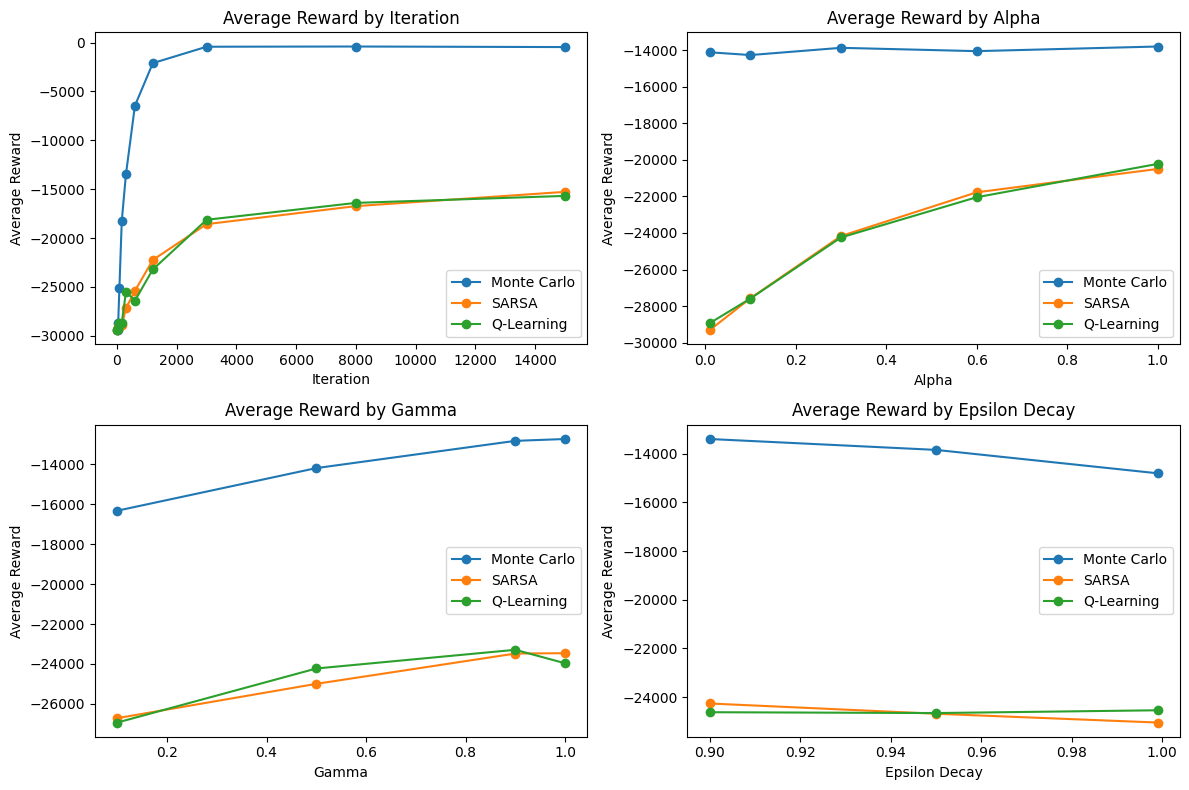

In [37]:
plot_grid_search(avg_rewardsMC, avg_rewardsSARSA,avg_rewardsQLEARN, labels=["Monte Carlo", "SARSA", "Q-Learning"])

Note: Performance is lowest around the time when the iterations end when epsilon hits epsilon_min.

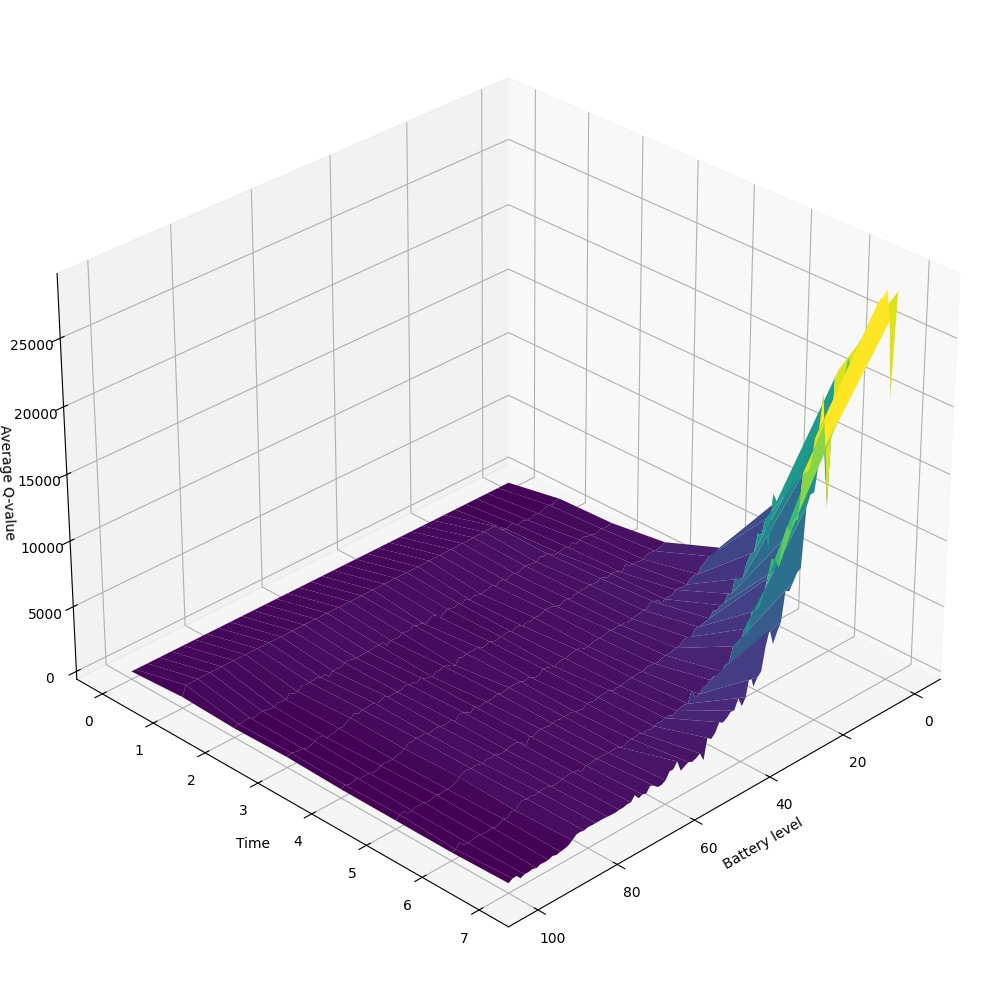

In [15]:
plot_q_table_3d(QLEARN_q_table,env.cap)

In [ ]:
max_time = 7
max_level = env.cap
parallel_coordinates_plot(DQN_q_table, actions, max_time, max_level)

In [ ]:
DQN_Agent2 = DQN_Agent_old(
    env=env, alpha=0.1, gamma=0.95, epsilon=1, epsilon_decay=0.99, epsilon_min=0.01,memory_size=10000, batch_size=32, target_update=10
)
DQN_q_table = DQN_Agent2.train(100,0)

Episode 1/100 - Reward: -3373.7453655821455, Epsilon: 1.00
Episode 2/100 - Reward: -318.6011904429191, Epsilon: 1.00
Episode 3/100 - Reward: -460.69269657703643, Epsilon: 1.00
Episode 4/100 - Reward: -67.01376213767917, Epsilon: 0.99
Episode 5/100 - Reward: -3703.421567679446, Epsilon: 0.91
Episode 6/100 - Reward: -80.86727170958326, Epsilon: 0.84
Episode 7/100 - Reward: -4065.353439825734, Epsilon: 0.78
Episode 8/100 - Reward: -3515.264134580505, Epsilon: 0.72
Episode 9/100 - Reward: -350.8691735197049, Epsilon: 0.66
Episode 10/100 - Reward: -202.04528862362505, Epsilon: 0.61
Episode 11/100 - Reward: -255.11201208611755, Epsilon: 0.56
Episode 12/100 - Reward: -3229.747580042601, Epsilon: 0.52
Episode 13/100 - Reward: -3964.138843557563, Epsilon: 0.48
Episode 14/100 - Reward: -288.38330254715686, Epsilon: 0.44
Episode 15/100 - Reward: -4215.572072538577, Epsilon: 0.41
Episode 16/100 - Reward: -7070.515468161069, Epsilon: 0.38
Episode 17/100 - Reward: -333.16550938635567, Epsilon: 0.35
